In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from pathlib import Path
import numpy as np
from utils_nlp import nlp_pipeline, extract_nouns
import multiprocessing as mp
from utils import  fetch_data, fetch_embeddings
from sklearn.cluster import DBSCAN
from topic_extractors.LDA_class import LDA, LDAParameters

[nltk_data] Downloading package stopwords to /home/ivo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ivo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ivo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
cwd_path = Path().absolute()
print("My current directory is : " + str(cwd_path))
path = cwd_path.parent
data_path = path/'data'
print("My data directory is : "+ str(data_path))

My current directory is : /home/ivo/Trabalho/Interviews/Siemens/task_1
My data directory is : /home/ivo/Trabalho/Interviews/Siemens/data


In [3]:
n_components = 10
n_top_words = 20
batch_size = 128
path_corpus_tokenized = data_path/"corpus_tokenized.pickle"
path_corpus_embeddings = data_path/"corpus_embeddings.pickle"
path_corpus_nouns = data_path/"corpus_nouns.pickle"
path_cluster_0_corpus = data_path/"cluster_0.pickle"
workers = mp.cpu_count() - 1

# Importing PreProcessed data

In [4]:
df = pd.read_csv (data_path/"preprocessed.csv")

In [5]:
corpus=df["Reviews"]
corpus.shape

(20453,)

# Feature Engineering

In [9]:
corpus_tokenized = fetch_data(nlp_pipeline,corpus,path_corpus_tokenized)

# Latent Dirichlet allocation (LDA)

The Latent Dirichlet Analysis(LDA) algorithm can be regarded as dimensionality reduction technique.It explains a set of observations(words) through unobserved groups(topics), and each group explains why some parts of the data are similar. 

A topic is considered to be a set of terms (i.e., individual words or phrases) that, taken together, suggest a shared theme. 

In [6]:
lda = LDA(cleaned_docs=corpus_tokenized,
    vectorizer=CountVectorizer(stop_words="english"),
    parameters=LDAParameters().dict()
    )

In [7]:
lda.fit()

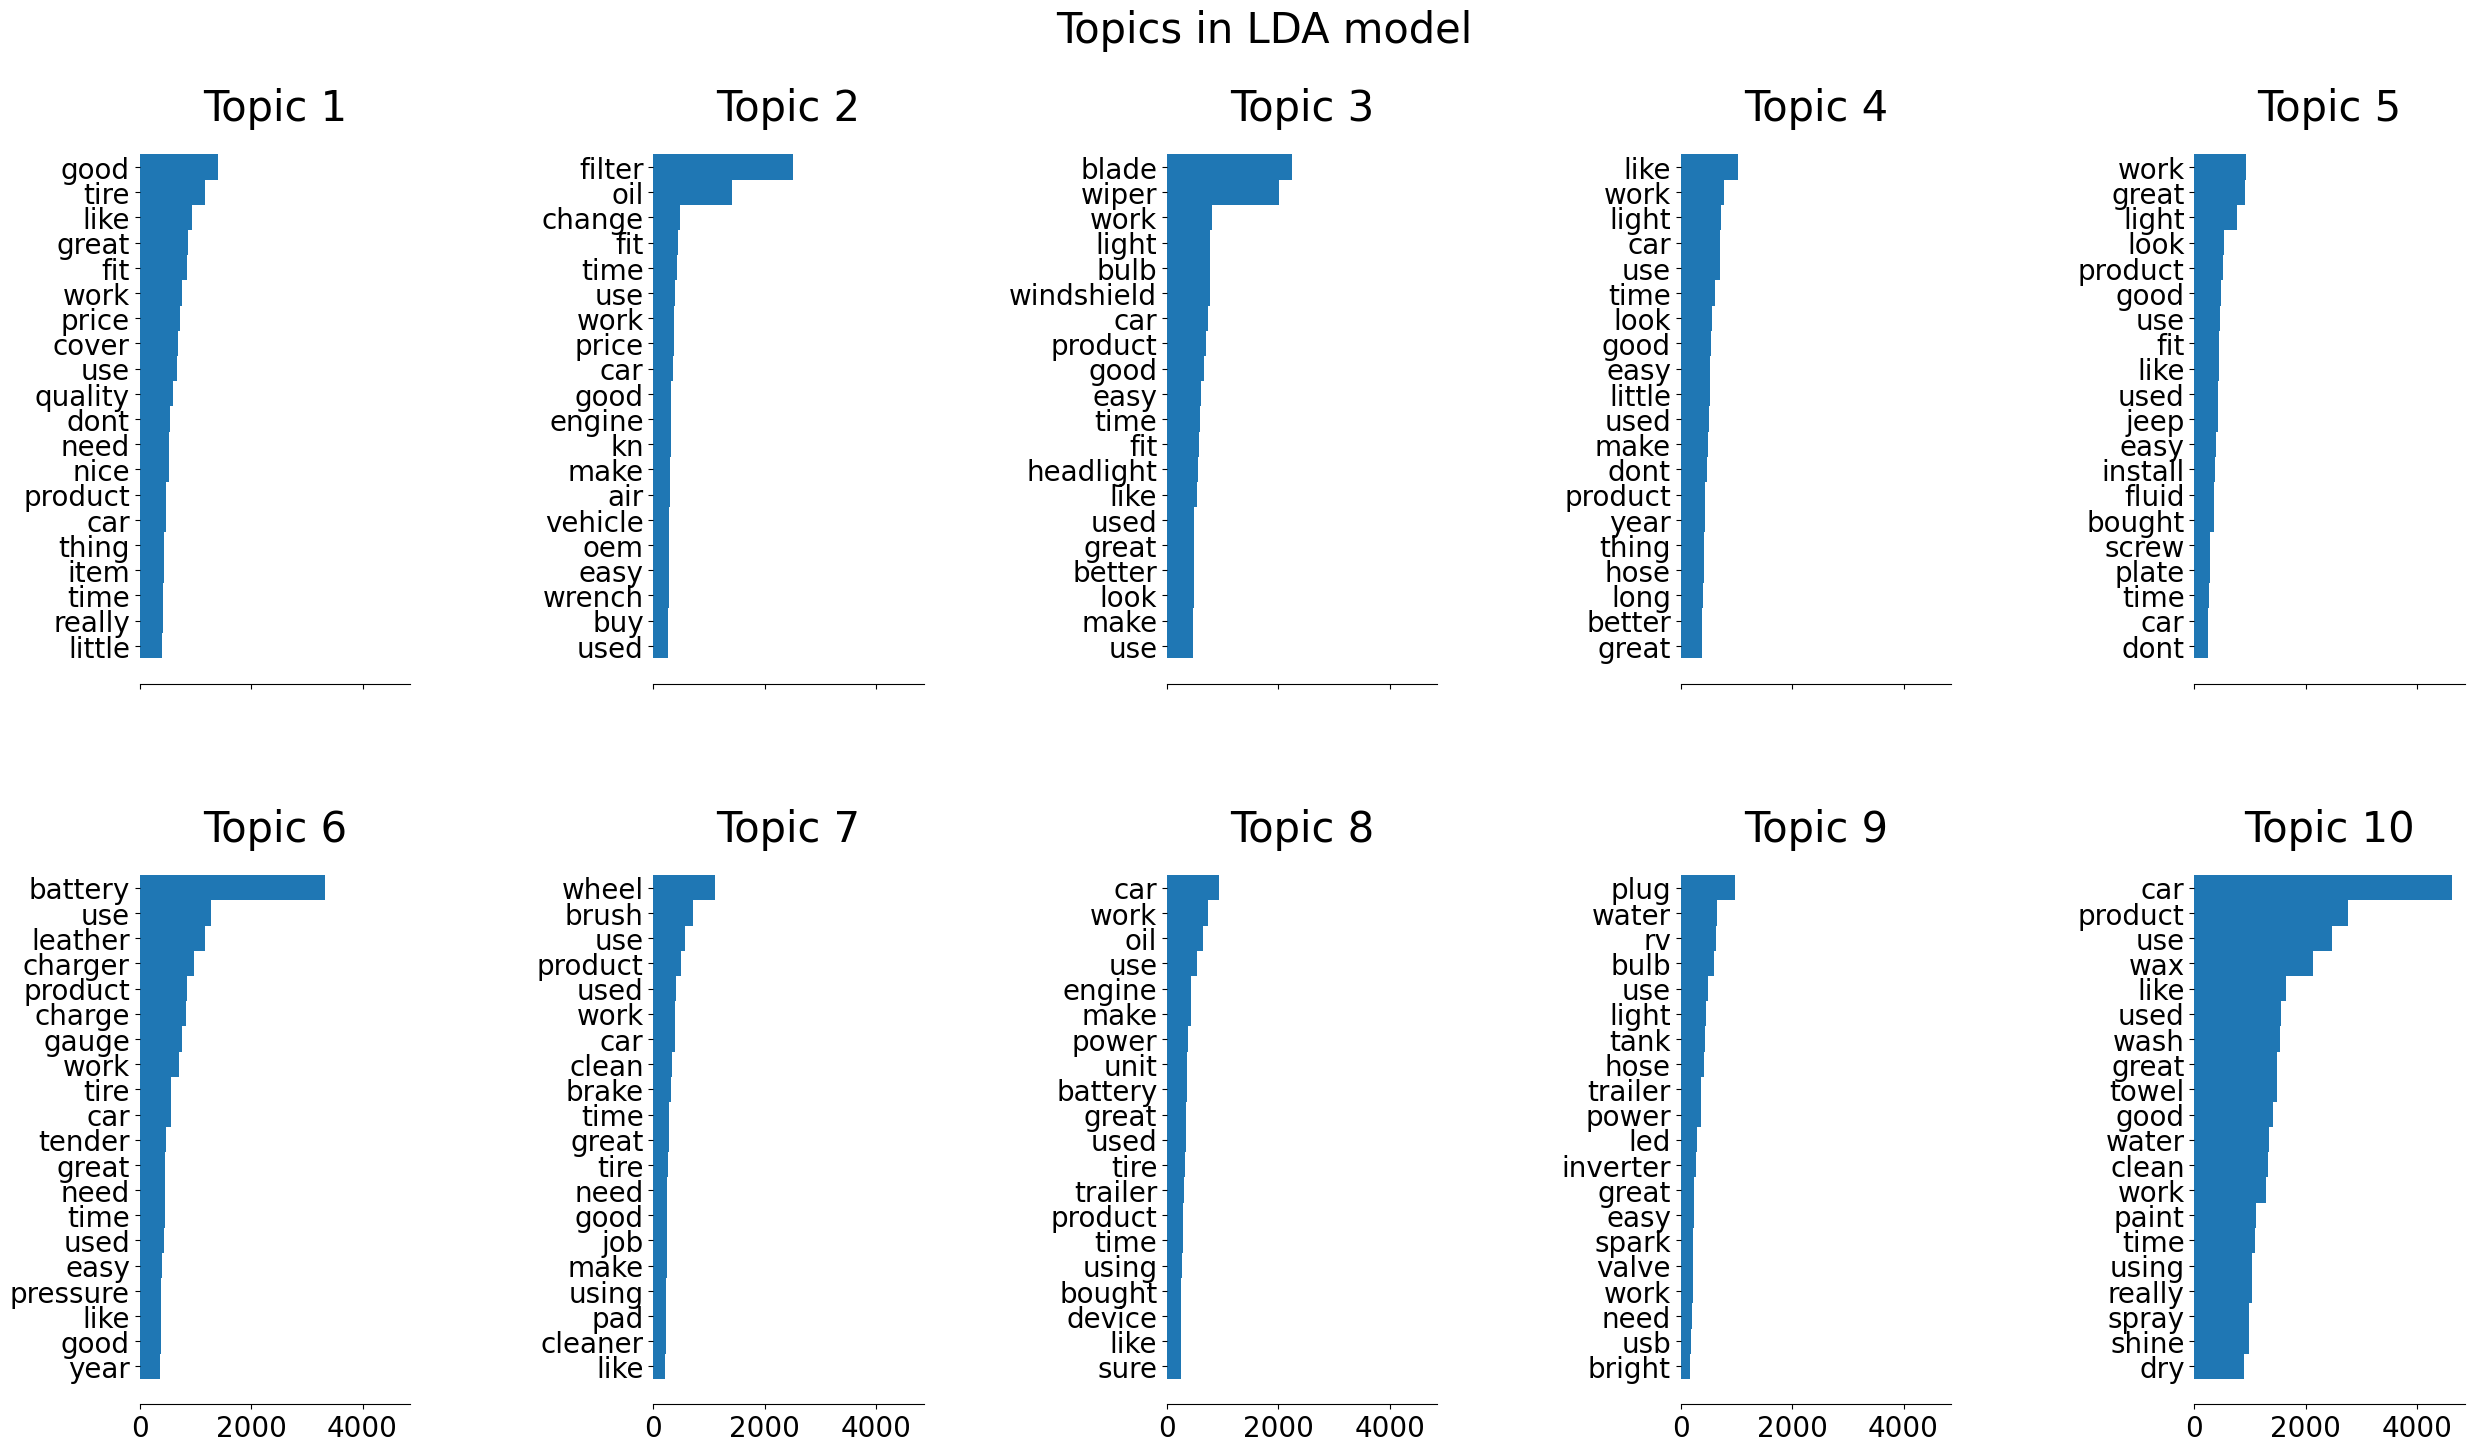

In [8]:
lda.plot_top_words(n_top_words, "Topics in LDA model")

### What customers think? 


In general, in all topics, customers tend to say that they are satisfied with the good performance of the products.

### What products they buy? 

We seem to have many products, all related to the automotive industry. Some of them are related to tyres, others to windshield blades, wax, batteries, oil, car fluid, etc. It's a bit difficult with just this simple analysis to really know specifically which products are being reviewed. We would need some extra analysis, for a more detailed conclusion.  

### How happy are the customers with those products?

The customers seem to be very satisfied. However, to be surer, we should find a way to group reviews by products, and the redo this topic extraction, and a sentiment analysis.

### What are the issues with them?

No major issues were found with this analysis, which is very odd, making me doubt about the way the data was cleaned in this notebook, and parameters values for the current model. It could also be due to too many reviews being grouped together. Assessing a subset of the reviews could improve our knowledge.

The following section is not mandatory according to the exercise instructions, but I was curious whether something could be done to improve on the previous results.

# Vectorizing Reviews, and Clustering them.

The main idea of this section is to try to cluster the reviews by products, i.e. by nouns. 
We saw, in the previous section, our analysis seemed to gather many different products under the same topic.

The plan now is to vectorize each review, and then cluster them in a way that when we check each cluster, it will be easier to recognize the topics.

Since we're in the presence of an unsupervised task, we would need to find an heuristics to optimize the parameters used in the clustering algorithm (possibly using the elbow method with the distortion metric). This can be very time consuming, for the purposes of this task, I'll just skip this optimization...

## Feature Engineering

In [6]:
corpus_nouns = fetch_data(extract_nouns,corpus,path_corpus_nouns)

## Vectorizing Reviews (Creating Embeddings)

To create the embedding, I use Hugging Face sentence-transformers, and pytorch multiprocessing module. More info can be found in the embeddings.py module

In [7]:
corpus_embeddings = fetch_embeddings(path_corpus_embeddings)
# takes approx. 35s to run for the first time, in my laptop.

## Clustering with DBScan

For DBScan, we need to choose its most important parameter, epsilon (eps), in an informed manner. One usual way is to plot the distances between the vectors, and choose a point where the graph has greatest curvature... This is just an heuristics. Other methods could be used.

In [8]:
from sklearn.neighbors import NearestNeighbors

In [9]:
nearest_neigh = NearestNeighbors(n_neighbors=2)
nbrs = nearest_neigh.fit(corpus_embeddings)
distances, indices = nbrs.kneighbors(corpus_embeddings)

In [10]:
import matplotlib.pyplot as plt

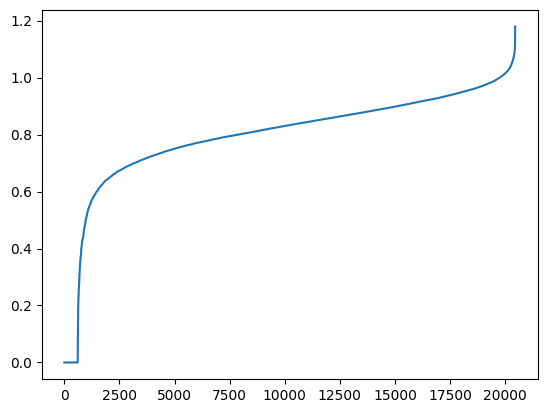

In [11]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [12]:
dbscan= DBSCAN(metric='euclidean', eps=0.65, min_samples=5).fit(corpus_embeddings)
# one advice to find the epsilon is to try at points where the curvature of the graph above
# is greater, i.e. 0.65 and 1. I tried with 1 and the results weren't that good.


In [13]:
len(np.unique(dbscan.labels_))
# How many clusters we found
# cluster -1 is a place holder for all the reviews that the DBScan algorith 
# couldn't find a pair to create a cluster, i.e. noisy samples.

55

So we now have 55 clusters... we must now check the reviews in those clusters. 

In [14]:
df["cluster_num"] = dbscan.labels_

## Topic Modelling on Cluster 0

In [134]:
cluster_0 = df[df["cluster_num"]==0]["Reviews"]

In [136]:
cluster_0_tokenized = fetch_data(nlp_pipeline,cluster_0,path_cluster_0_corpus)

In [138]:
lda_0 = LDA(cleaned_docs=cluster_0_tokenized,
    vectorizer=CountVectorizer(stop_words="english"),
    parameters=LDAParameters(n_components=5).dict()
    )

In [139]:
lda_0.fit()

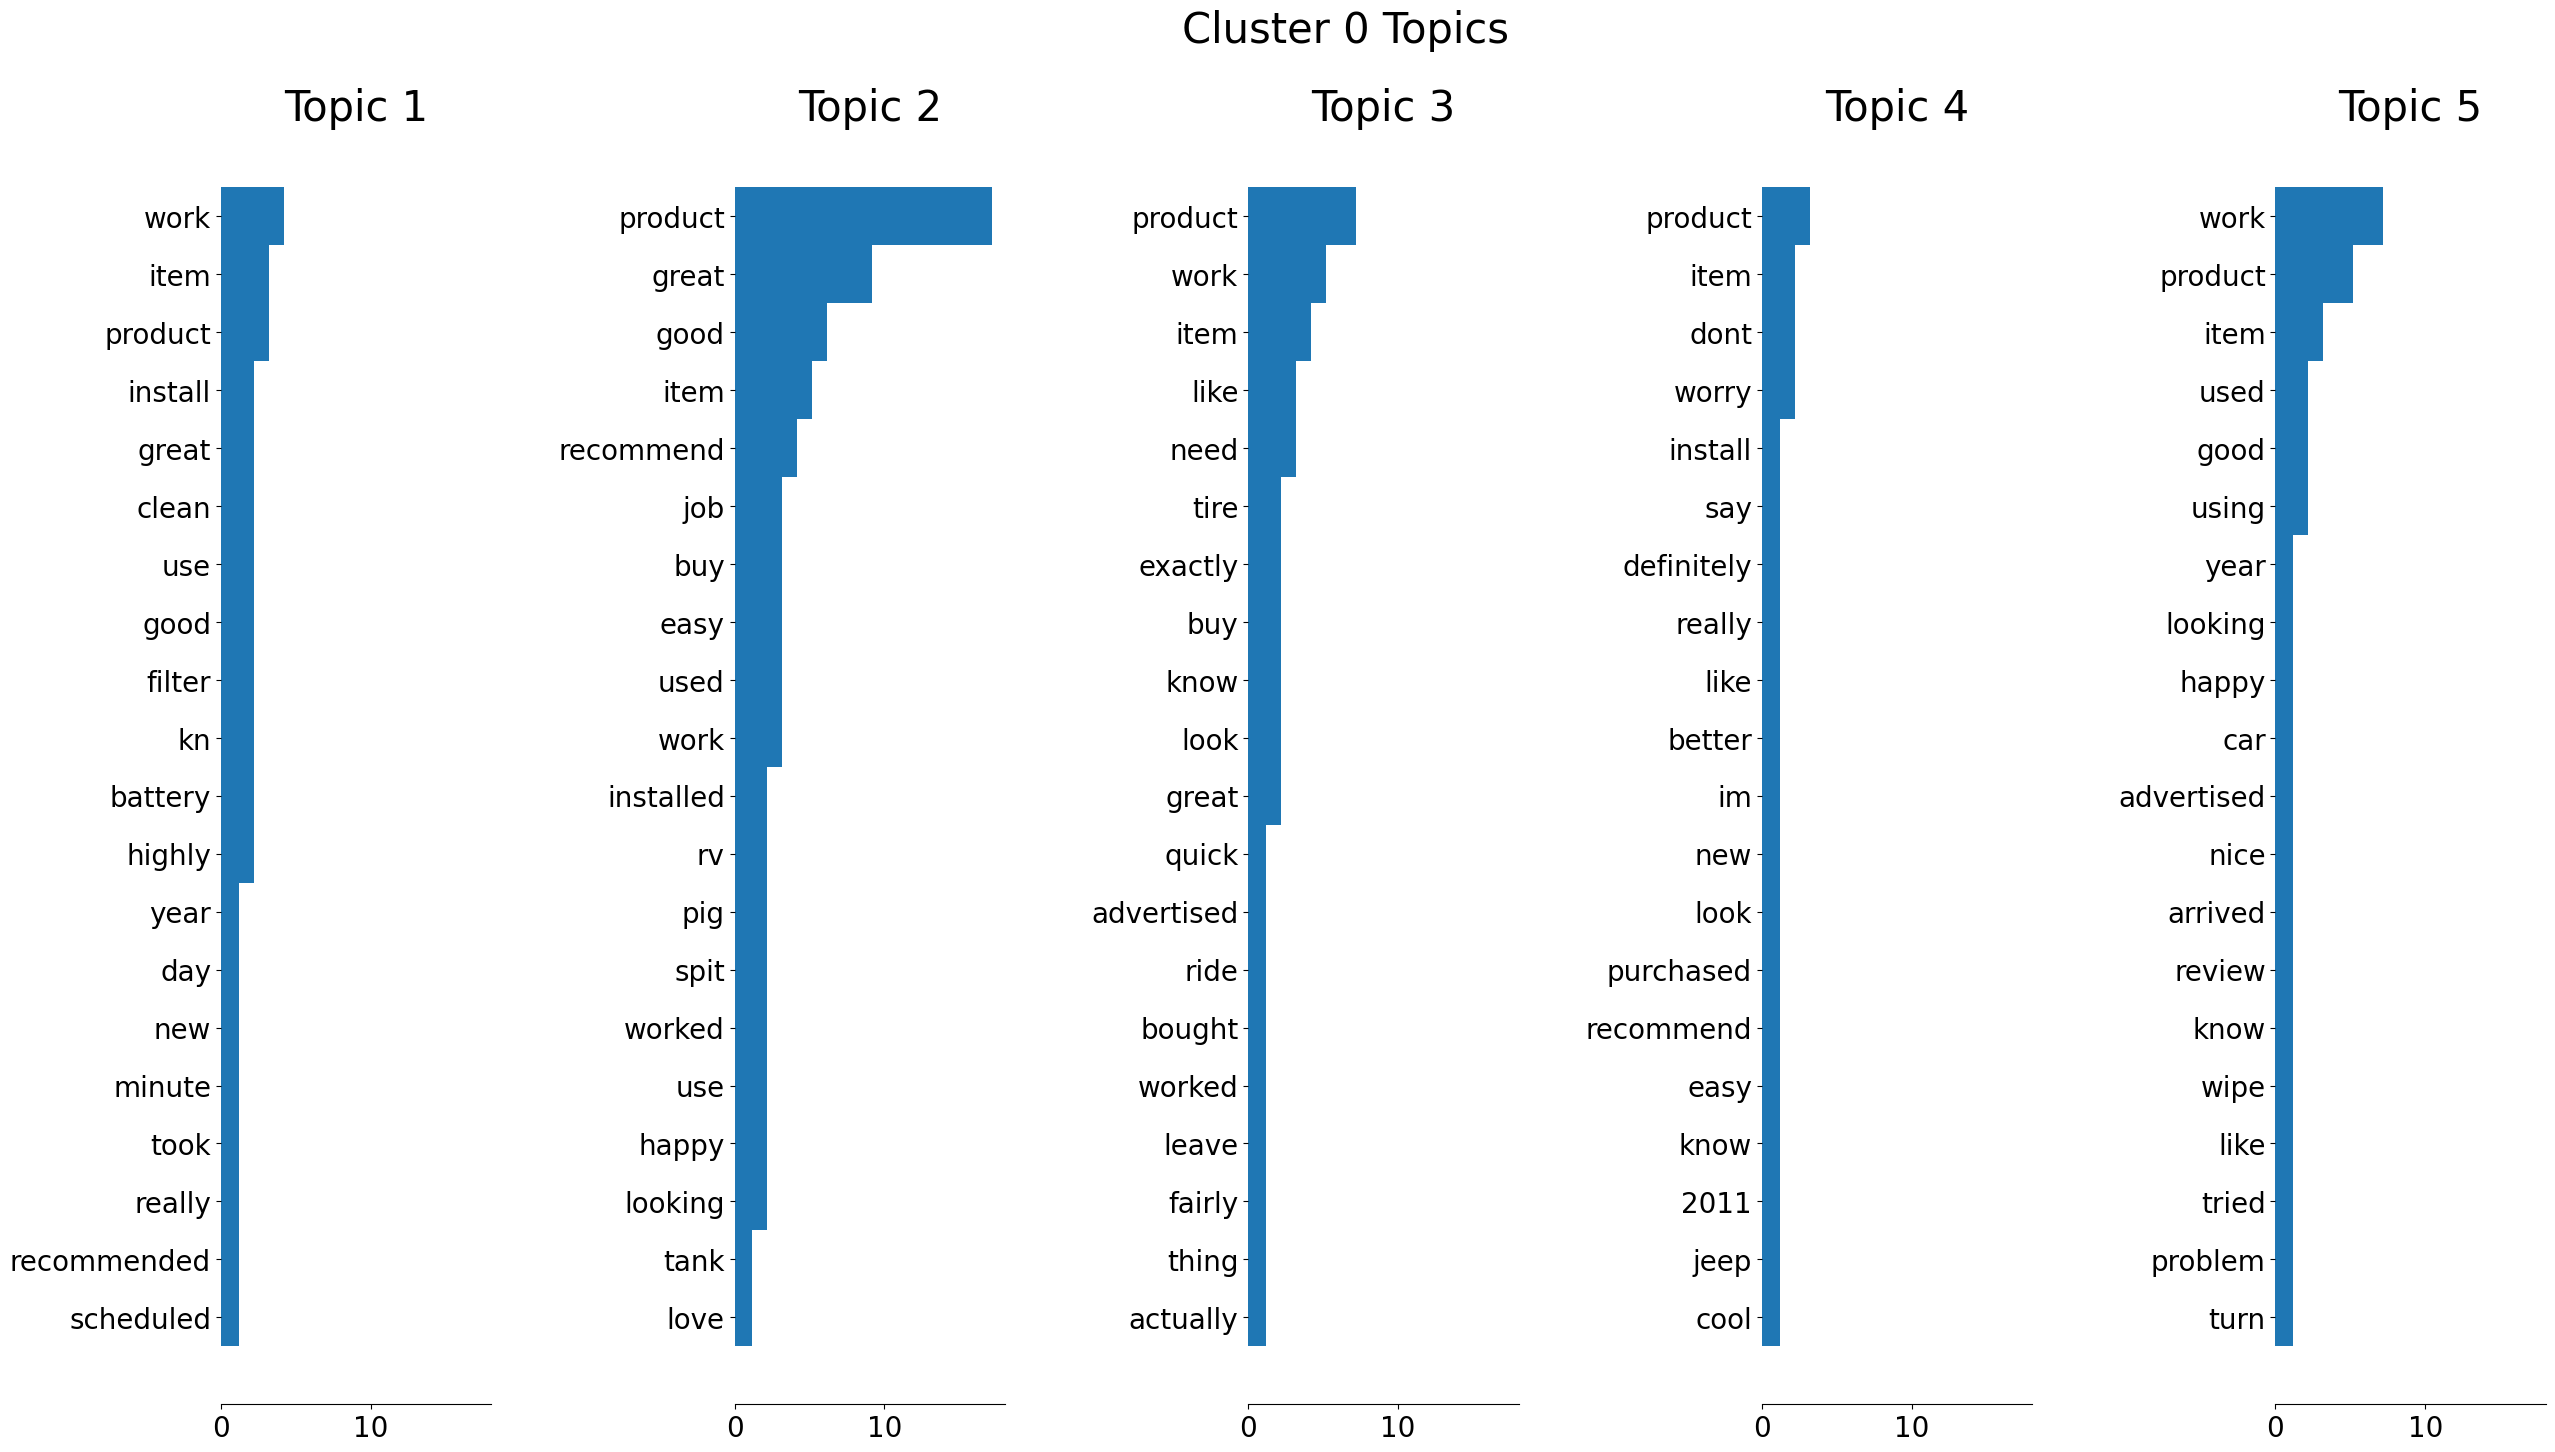

In [140]:
lda_0.plot_top_words(n_top_words=n_top_words,title="Cluster 0 Topics")

We can notice this cluster reviews focus on nouns such as product, work... The costumers seem `happy`.
Now, we could do a similar analysis for the remaining clusters to have a better idea of the other possible topics/products/opinions.

# Topic Modelling on another (randomly chosen) cluster

In [15]:
cluster = df[df["cluster_num"]==5]["Reviews"]

In [16]:
len(cluster)

44

In [17]:
cluster_engineered = fetch_data(nlp_pipeline,cluster)

In [18]:
lda_cluster = LDA(cleaned_docs=cluster_engineered,
    vectorizer=CountVectorizer(stop_words="english"),
    parameters=LDAParameters(n_components=5).dict()
    )

In [19]:
lda_cluster.fit()

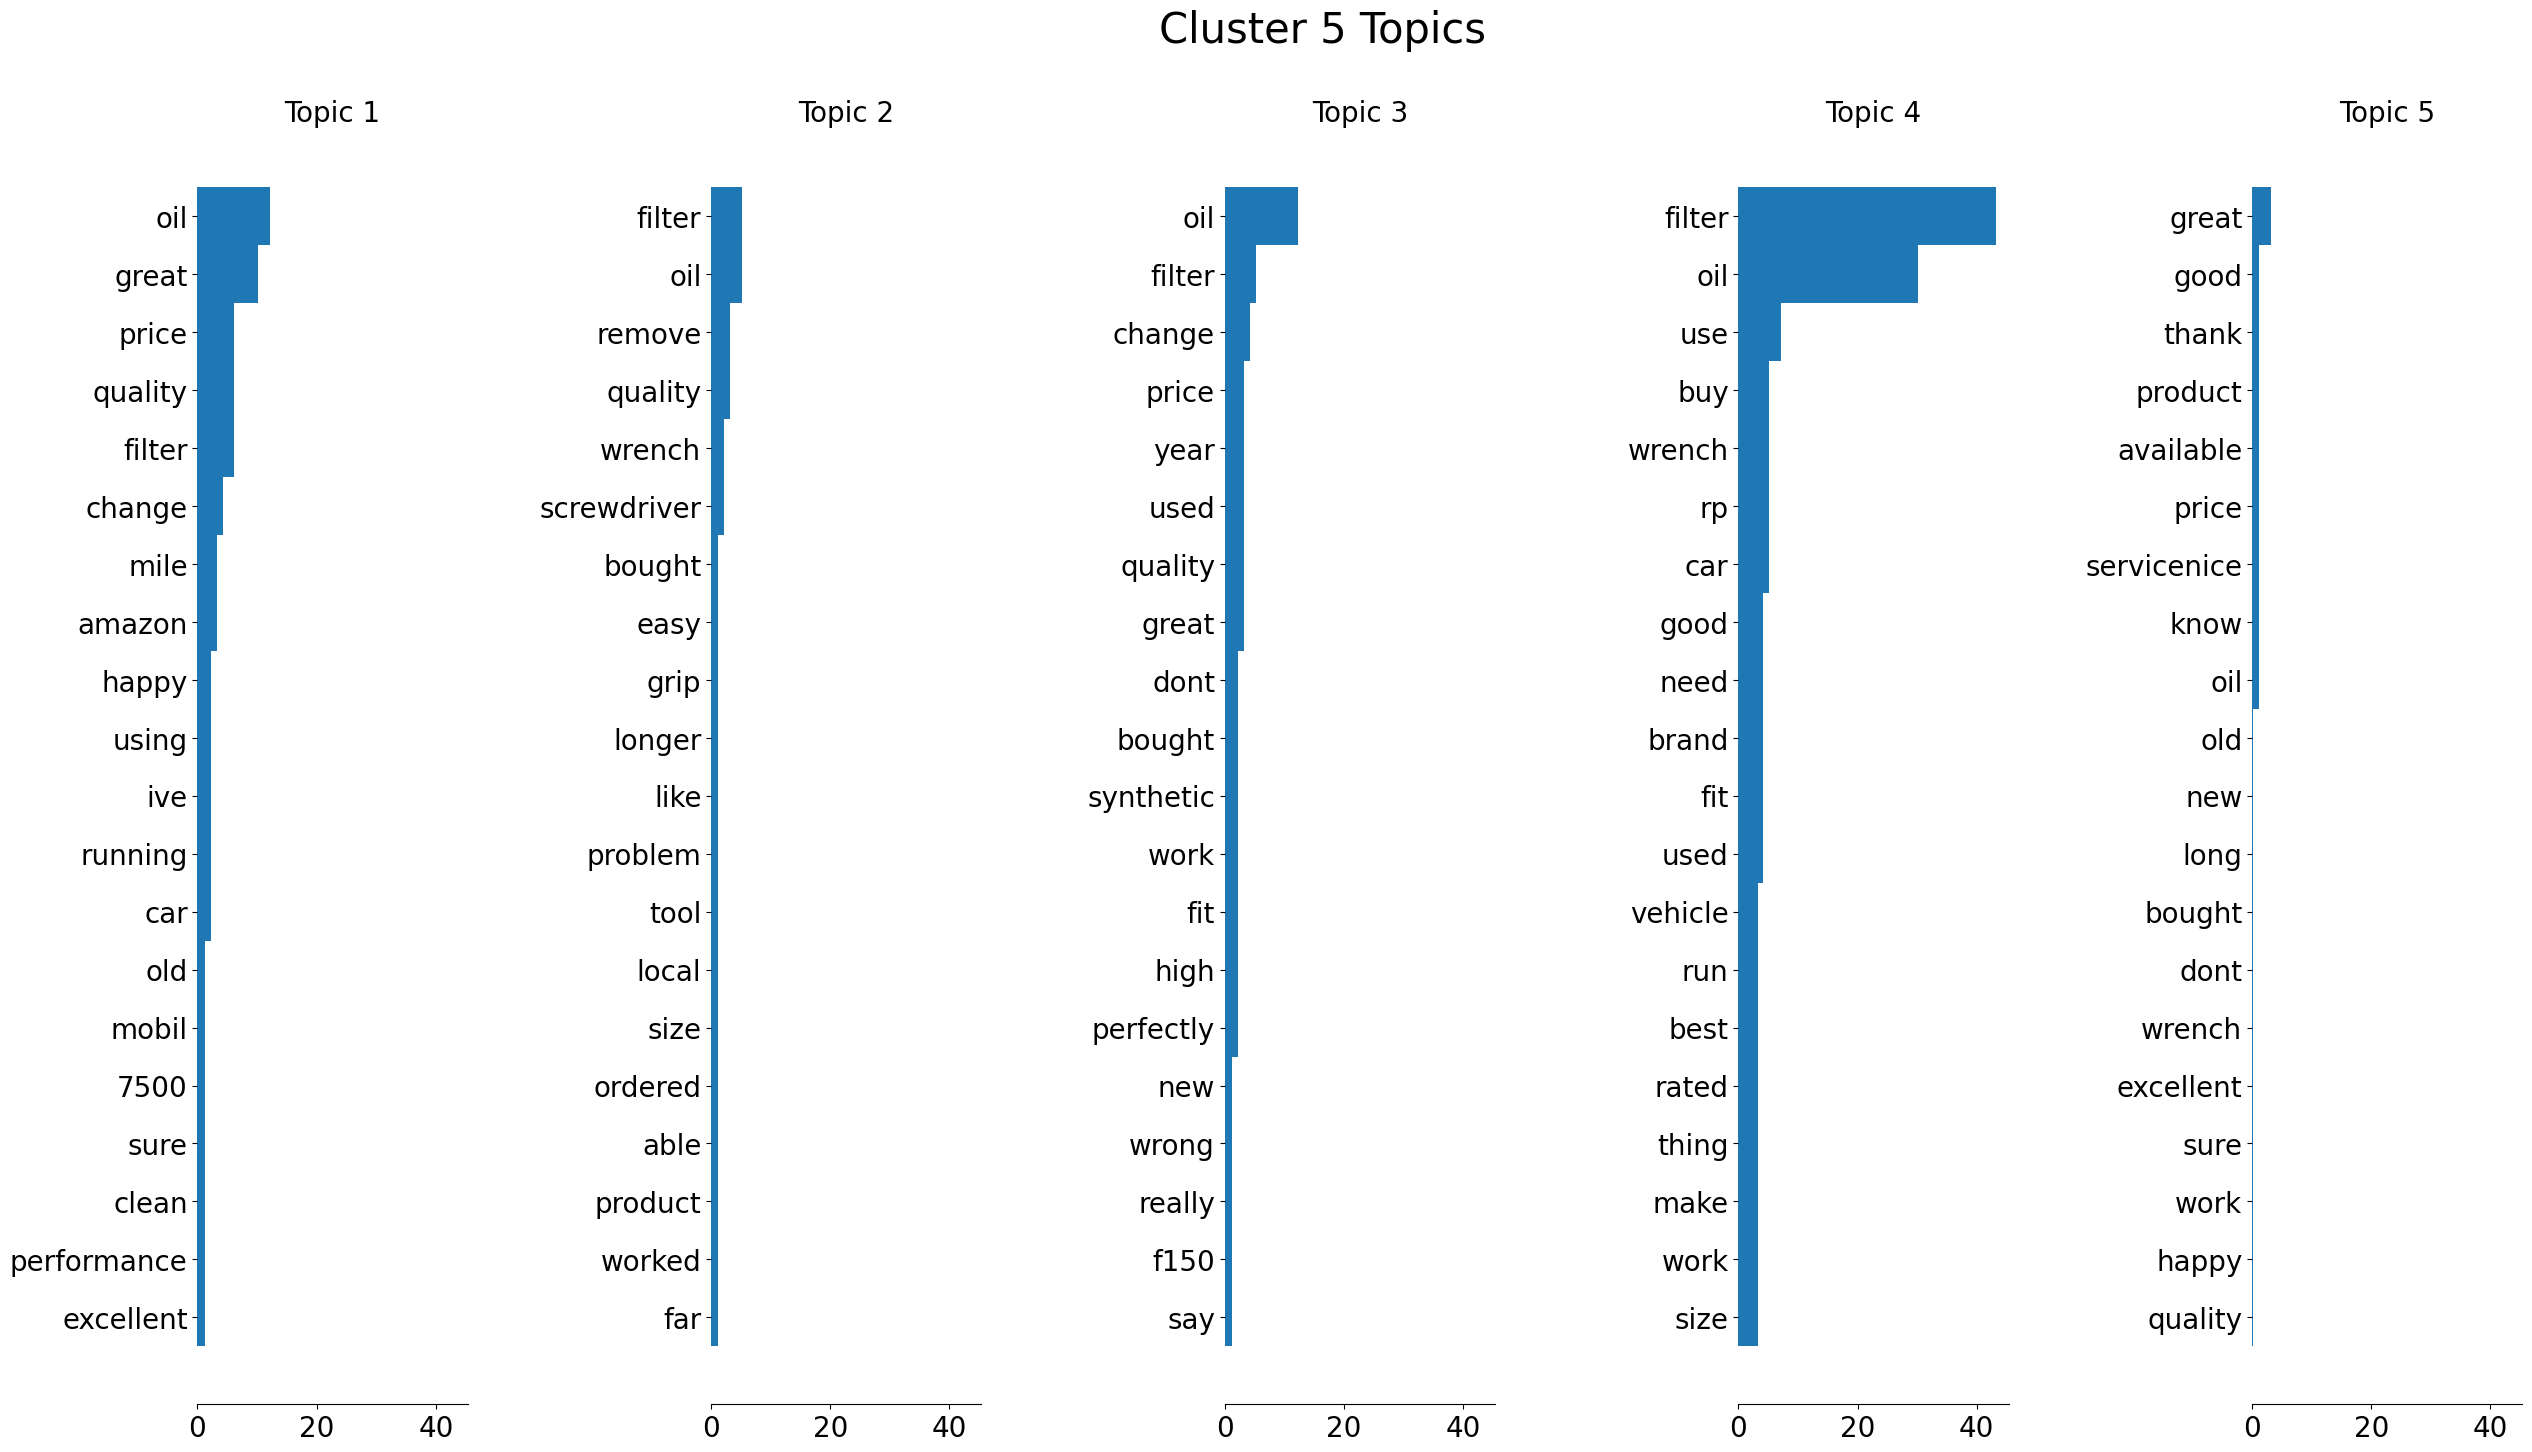

In [20]:
lda_cluster.plot_top_words(n_top_words=n_top_words,title="Cluster 5 Topics")

We can notice this cluster reviews focus in general on a filter oil, and that service was nice, for the price that was paid. There could be some smaller issue though. To be surer, we'll do, in another notebook, a summarization of all the reviews in this cluster to showcase another NLP task.

## Saving Dataframe for further analysis

In [21]:
df.to_csv("../data/clusterized_dataframe.csv")